## Packages

In [1]:
from datetime import datetime, timedelta
import pandas as pd
import os
from sunpy.net import Fido, attrs as a
from sunpy.timeseries import TimeSeries
from sunpy.timeseries.sources.goes import XRSTimeSeries
import astropy.units as u
from sunkit_instruments.goes_xrs import calculate_temperature_em
import matplotlib.pyplot as plt
import numpy as np
from sunpy.data import manager
import netCDF4 as nc
import os
import pandas as pd
from datetime import datetime, timedelta
import copy
from matplotlib import colormaps
list(colormaps)
#from colorspacious import cspace_converter
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib.dates as mdates
from matplotlib.ticker import LogFormatter
from matplotlib.ticker import LogFormatterMathtext
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
from IPython.display import HTML, display
import matplotlib.pyplot as plt
import seaborn as sns
import re
import glob

## Funciones Estadística

In [ ]:
def create_fai_statistics_table(df_anticipation_time, analysis_dir, output_filename=None):
    """
    Create comprehensive FAI statistics table by flare class and save to CSV.
    
    Parameters:
    - df_anticipation_time: DataFrame with FAI data
    - output_filename: Name for output CSV file (optional)
    
    Returns:
    - DataFrame with FAI statistics
    """
    
    # Create summary by ClassLetter
    stats_by_class = df_anticipation_time.groupby('ClassLetter').agg(
        Total_Flares=('ClassLetter', 'count'),
        With_FAI=('FAIalerts_W', lambda x: (x != 0).sum()),
        Without_FAI=('FAIalerts_W', lambda x: (x == 0).sum())
    ).reset_index()
    
    # Calculate percentages
    stats_by_class['Percent_With_FAI'] = (stats_by_class['With_FAI'] / stats_by_class['Total_Flares'] * 100).round(2)
    stats_by_class['Percent_Without_FAI'] = (stats_by_class['Without_FAI'] / stats_by_class['Total_Flares'] * 100).round(2)
    
    # Order by flare class (A, B, C, M, X)
    class_order = ['A', 'B', 'C', 'M', 'X']
    stats_by_class['ClassLetter'] = pd.Categorical(stats_by_class['ClassLetter'], 
                                                  categories=class_order, ordered=True)
    stats_by_class = stats_by_class.sort_values('ClassLetter')
    
    # Calculate totals for all classes
    total_flares = len(df_anticipation_time)
    total_with_fai = (df_anticipation_time['FAIalerts_W'] != 0).sum()
    total_without_fai = (df_anticipation_time['FAIalerts_W'] == 0).sum()
    percent_with_fai = (total_with_fai / total_flares * 100).round(2)
    percent_without_fai = (total_without_fai / total_flares * 100).round(2)
    
    # Create total row
    total_row = pd.DataFrame({
        'ClassLetter': ['TOTAL'],
        'Total_Flares': [total_flares],
        'With_FAI': [total_with_fai],
        'Without_FAI': [total_without_fai],
        'Percent_With_FAI': [percent_with_fai],
        'Percent_Without_FAI': [percent_without_fai]
    })
    
    # Combine class statistics with total row
    final_stats = pd.concat([stats_by_class, total_row], ignore_index=True)
        
    # Reorder columns for better readability
    column_order = [
        'ClassLetter', 
        'Total_Flares', 
        'With_FAI', 
        'Without_FAI', 
        'Percent_With_FAI', 
        'Percent_Without_FAI'
    ]
    final_stats = final_stats[column_order]
    
    # Display the table
    print("FAI Statistics by Flare Class")
    print("=" * 90)
    print(final_stats.to_string(index=False))
    print("=" * 90)
    
    # Print summary
    print(f"\nSummary Statistics:")
    print(f"Total flares analyzed: {total_flares}")
    print(f"Flares with FAI alerts: {total_with_fai} ({percent_with_fai}%)")
    print(f"Flares without FAI alerts: {total_without_fai} ({percent_without_fai}%)")
    
    # Save to CSV if filename provided
    if output_filename:
        # Ensure it has .csv extension
        if not output_filename.endswith('.csv'):
            output_filename += '.csv'
        
        output_path = os.path.join(analysis_dir, output_filename)
        final_stats.to_csv(output_path, index=False)
        print(f"\nStatistics table saved to: {output_path}")
    
    return final_stats


#
##

## Parameters

In [19]:
n=185
# nuevo número de días
new_n = 148
fecha_actual = "2025-11-11"

window_minutes=30
fai_temp_range = (7, 14)
fai_em_threshold = 0.005
date_column = "date"
duration = True
FAI_duration = 3
filter_flare_coincidence = True
method = "filtered" # "all", "true" o "filtered"
flares = "valid" # "valid", "CMX"

## Carpeta para estadística

In [3]:
analysis_dir = os.path.join(f"Analysis_FAI")
# Crear carpeta de análisis (si no existe) y mostrar mensaje
if os.path.exists(analysis_dir ):
    print(f"⚠️ La carpeta de análisis ya existía: {analysis_dir }")
else:
    os.makedirs(analysis_dir , exist_ok=True)
    print(f"📁 Carpeta de análisis creada: {analysis_dir}")

# Crear subcarpeta para guardar resultados de análisis
analysis_esp = os.path.join(analysis_dir, f"Analysis_FAI_T{fai_temp_range[0]}-{fai_temp_range[1]}_EM{fai_em_threshold}_dur{FAI_duration}min")
# Crear carpeta de análisis (si no existe) y mostrar mensaje
if os.path.exists(analysis_esp ):
    print(f"⚠️ La carpeta de análisis ya existía: {analysis_esp }")
else:
    os.makedirs(analysis_esp , exist_ok=True)
    print(f"📁 Carpeta de análisis creada: {analysis_esp}")

folder = f"Statictics_{method}_W{window_minutes}min"

# Crear subcarpeta para guardar resultados de análisis
statictics_dir = os.path.join(analysis_esp, folder)
# Crear subcarpeta para guardar resultados de análisis (si no existe) y mostrar mensaje
if os.path.exists(statictics_dir):
    print(f"⚠️ La carpeta de análisis ya existía: {statictics_dir}")
else:
    os.makedirs(statictics_dir , exist_ok=True)
    print(f"📁 Carpeta de análisis creada: {statictics_dir}")




⚠️ La carpeta de análisis ya existía: Analysis_FAI
⚠️ La carpeta de análisis ya existía: Analysis_FAI/Analysis_FAI_T7-14_EM0.005_dur3min
📁 Carpeta de análisis creada: Analysis_FAI/Analysis_FAI_T7-14_EM0.005_dur3min/Statictics_filtered_W30min


## Valid Data 

In [20]:
output_dir = f"Data_for_{n}_days"

# Path of cleaned data in csv
csv_path_full_valid = f"{output_dir}/df_full_{new_n}_valid.csv"
# Path of valid flares: 
csv_path_flares = f"{output_dir}/df_flares_{new_n}_{flares}.csv"
# Path of df_full
csv_path_full = f"{output_dir}/all_df_full_{n}.csv"

# Verificar existencia de archivos y avisar
if not os.path.exists(csv_path_full_valid):
    print(f"⚠️ No se encontró el archivo GOES: {csv_path_full_valid}")
else:
    print(f"✅ Archivo GOES encontrado: {csv_path_full_valid}")

if not os.path.exists(csv_path_flares):
    print(f"⚠️ No se encontró el archivo de flares: {csv_path_flares}")
else:
    print(f"✅ Archivo de flares encontrado: {csv_path_flares}")

if not os.path.exists(csv_path_full):
    print(f"⚠️ No se encontró el archivo de flares: {csv_path_full}")
else:
    print(f"✅ Archivo de flares encontrado: {csv_path_full}")

df_full_valid = pd.read_csv(csv_path_full_valid)
df_flares_valid = pd.read_csv(csv_path_flares)
df_full = pd.read_csv(csv_path_full)

✅ Archivo GOES encontrado: Data_for_185_days/df_full_148_valid.csv
✅ Archivo de flares encontrado: Data_for_185_days/df_flares_148_valid.csv
✅ Archivo de flares encontrado: Data_for_185_days/all_df_full_185.csv


## Data_method

In [5]:
# Path of anticipation_time
csv_path_anticipation_time = f"{analysis_esp}/df_anticipation_time_{method}_(W_{window_minutes})_T{fai_temp_range[0]}-{fai_temp_range[1]}_EM{fai_em_threshold}_dur{FAI_duration}min.csv"
# Path of fai_all
csv_path_fai_all = f"{analysis_esp}/df_fai_all_T{fai_temp_range[0]}-{fai_temp_range[1]}_EM{fai_em_threshold}_dur{FAI_duration}min.csv"
# Path of fai_selected
csv_path_fai_selected = f"{analysis_esp}/df_fai_{method}_T{fai_temp_range[0]}-{fai_temp_range[1]}_EM{fai_em_threshold}_dur{FAI_duration}min.csv"
# Path of df_fai_assoc
csv_path_fai_assoc = f"{analysis_esp}/df_fai_assoc2_{method}_(W_{window_minutes})_T{fai_temp_range[0]}-{fai_temp_range[1]}_EM{fai_em_threshold}_dur{FAI_duration}min.csv"

if not os.path.exists(csv_path_anticipation_time):
    print(f"⚠️ No se encontró el archivo de flares: {csv_path_anticipation_time}")
else:
    print(f"✅ Archivo de flares encontrado: {csv_path_anticipation_time}")
if not os.path.exists(csv_path_fai_all):
    print(f"⚠️ No se encontró el archivo de flares: {csv_path_fai_all}")
else:
    print(f"✅ Archivo de flares encontrado: {csv_path_fai_all}")
if not os.path.exists(csv_path_fai_selected):
    print(f"⚠️ No se encontró el archivo de flares: {csv_path_fai_selected}")
else:
    print(f"✅ Archivo de flares encontrado: {csv_path_fai_selected}")
if not os.path.exists(csv_path_fai_assoc):
    print(f"⚠️ No se encontró el archivo de flares: {csv_path_fai_assoc}")
else:
    print(f"✅ Archivo de flares encontrado: {csv_path_fai_assoc}")


df_anticipation_time = pd.read_csv(csv_path_anticipation_time)
df_fai_all = pd.read_csv(csv_path_fai_all)
df_fai_selected = pd.read_csv(csv_path_fai_selected)
df_fai_assoc = pd.read_csv(csv_path_fai_assoc)



✅ Archivo de flares encontrado: Analysis_FAI/Analysis_FAI_T7-14_EM0.005_dur3min/df_anticipation_time_filtered_(W_30)_T7-14_EM0.005_dur3min.csv
✅ Archivo de flares encontrado: Analysis_FAI/Analysis_FAI_T7-14_EM0.005_dur3min/df_fai_all_T7-14_EM0.005_dur3min.csv
✅ Archivo de flares encontrado: Analysis_FAI/Analysis_FAI_T7-14_EM0.005_dur3min/df_fai_filtered_T7-14_EM0.005_dur3min.csv
✅ Archivo de flares encontrado: Analysis_FAI/Analysis_FAI_T7-14_EM0.005_dur3min/df_fai_assoc2_filtered_(W_30)_T7-14_EM0.005_dur3min.csv


## Statistics

In [18]:
stats_flares = create_fai_statistics_table(df_anticipation_time, analysis_dir=statictics_dir,
                                           output_filename="Flares_Class_stats")

FAI Statistics by Flare Class
ClassLetter  Total_Flares  With_FAI  Without_FAI  Percent_With_FAI  Percent_Without_FAI
          B            48        19           29             39.58                60.42
          C           914       676          238             73.96                26.04
          M           333       209          124             62.76                37.24
          X           138        91           47             65.94                34.06
      TOTAL          1433       995          438             69.43                30.57

Summary Statistics:
Total flares analyzed: 1433
Flares with FAI alerts: 995 (69.43%)
Flares without FAI alerts: 438 (30.57%)

Statistics table saved to: Analysis_FAI/Analysis_FAI_T7-14_EM0.005_dur3min/Statictics_filtered_W30min/Flares_Class_stats.csv


In [ ]:
def create_fai_confusion_matrix(df_anticipation_time, df_fai_assoc2):
    """
    Create confusion matrix and calculate performance metrics for FAI alert system
    """
    
    # ============================================================================
    # 1. DEFINE TRUTHS AND PREDICTIONS - CORRECTED
    # ============================================================================
    
    # True Positives (TP): FAI alerts that ARE associated with flares (correct predictions)
    tp_alerts = len(df_fai_assoc2[df_fai_assoc2['Associated_Flare'] == True])
    
    # False Positives (FP): FAI alerts that are NOT associated with flares (false alarms)
    fp_alerts = len(df_fai_assoc2[df_fai_assoc2['Associated_Flare'] == False])
    
    # False Negatives (FN): Flares that occurred but had NO FAI alerts
    fn_flares = len(df_anticipation_time[df_anticipation_time['FAIalerts_W'] == 0])
    
    # True Positives in terms of flares: Flares that were correctly alerted
    tp_flares = len(df_anticipation_time[df_anticipation_time['FAIalerts_W'] > 0])
    
    # ============================================================================
    # 2. CALCULATE BASIC METRICS
    # ============================================================================
    
    total_flares = len(df_anticipation_time)
    total_fai_alerts = len(df_fai_assoc2)
    
    tp = tp_alerts  # Correct FAI alerts (from alerts perspective)
    fp = fp_alerts  # False alarm FAI alerts
    fn = fn_flares  # Missed flares
    # tn = Not directly calculable
    
    print("=== FAI SYSTEM CONFUSION MATRIX ===")
    print(f"Total flares: {total_flares}")
    print(f"Total FAI alerts: {total_fai_alerts}")
    print()
    print("               ┌─────────────────┬─────────────────┐")
    print("               │   REAL FLARE    │  NO REAL FLARE  │")
    print("┌──────────────┼─────────────────┼─────────────────┤")
    print(f"│ FAI ALERT    │    TP: {tp:4d}     │    FP: {fp:4d}     │")
    print("│    YES       │                 │                 │")
    print("├──────────────┼─────────────────┼─────────────────┤")
    print(f"│ FAI ALERT    │    FN: {fn:4d}     │    TN:   N/A    │")
    print("│    NO        │                 │                 │")
    print("└──────────────┴─────────────────┴─────────────────┘")
    print()
    
    # ============================================================================
    # 3. CALCULATE PERFORMANCE METRICS
    # ============================================================================
    
    # Metrics based on flare detection (from flares perspective)
    detection_rate = tp_flares / total_flares * 100 if total_flares > 0 else 0
    miss_rate = fn / total_flares * 100 if total_flares > 0 else 0
    
    # Metrics based on alerts (from alerts perspective)
    false_alarm_rate = fp / total_fai_alerts * 100 if total_fai_alerts > 0 else 0
    precision = tp / (tp + fp) * 100 if (tp + fp) > 0 else 0
    
    # Additional metrics
    if (tp_flares + fn) > 0:
        recall = tp_flares / (tp_flares + fn) * 100  # Same as detection rate
    else:
        recall = 0
        
    if (precision + recall) > 0:
        f1_score = 2 * (precision * recall) / (precision + recall)
    else:
        f1_score = 0
    
    print("=== PERFORMANCE METRICS ===")
    print(f"• Detection Rate (Recall):     {detection_rate:.1f}%")
    print(f"• False Alarm Rate:            {false_alarm_rate:.1f}%")
    print(f"• Precision:                   {precision:.1f}%")
    print(f"• Miss Rate:                   {miss_rate:.1f}%")
    print(f"• F1-Score:                    {f1_score:.3f}")
    print()
    
    # ============================================================================
    # 4. METRICS BY FLARE CLASS
    # ============================================================================
    
    print("=== METRICS BY FLARE CLASS ===")
    class_metrics = []
    
    for class_letter in ['A', 'B', 'C', 'M', 'X']:
        class_flares = df_anticipation_time[df_anticipation_time['ClassLetter'] == class_letter]
        if len(class_flares) > 0:
            class_tp = len(class_flares[class_flares['FAIalerts_W'] > 0])
            class_fn = len(class_flares[class_flares['FAIalerts_W'] == 0])
            class_detection_rate = class_tp / len(class_flares) * 100
            
            class_metrics.append({
                'Class': class_letter,
                'Total_Flares': len(class_flares),
                'Detected': class_tp,
                'Missed': class_fn,
                'Detection_Rate': class_detection_rate
            })

    # Calculate totals
    total_all_flares = sum([cm['Total_Flares'] for cm in class_metrics])
    total_detected = sum([cm['Detected'] for cm in class_metrics])
    total_missed = sum([cm['Missed'] for cm in class_metrics])
    overall_detection_rate = total_detected / total_all_flares * 100

    # Add total row
    total_row = {
        'Class': 'TOTAL',
        'Total_Flares': total_all_flares,
        'Detected': total_detected,
        'Missed': total_missed,
        'Detection_Rate': overall_detection_rate
    }

    class_metrics.append(total_row)
    
    # Display class metrics table
    metrics_df = pd.DataFrame(class_metrics)
    if not metrics_df.empty:
        print(metrics_df.to_string(index=False, float_format='%.1f'))
        print()
    
    # ============================================================================
    # 5. ADDITIONAL STATISTICS
    # ============================================================================
    
    print("=== ADDITIONAL STATISTICS ===")
    
    # Overall system efficiency
    total_correct_alerts = tp
    total_incorrect_alerts = fp
    
    print(f"Correct FAI alerts:        {total_correct_alerts} ({total_correct_alerts/total_fai_alerts*100:.1f}%)")
    print(f"Incorrect FAI alerts:      {total_incorrect_alerts} ({total_incorrect_alerts/total_fai_alerts*100:.1f}%)")
    
    # Signal-to-noise ratio
    if total_incorrect_alerts > 0:
        signal_to_noise = total_correct_alerts / total_incorrect_alerts
        print(f"Signal-to-Noise Ratio:      {signal_to_noise:.2f}")
    
    # Efficiency by flare type
    print(f"\nDetected flares:           {tp_flares}/{total_flares} ({detection_rate:.1f}%)")
    print(f"Missed flares:             {fn}/{total_flares} ({miss_rate:.1f}%)")
    
    # Alert efficiency
    print(f"\nAlert Efficiency:")
    print(f"FAI alerts per detected flare: {total_correct_alerts/tp_flares:.2f}" if tp_flares > 0 else "N/A")
    
    return {
        'tp_alerts': tp,
        'tp_flares': tp_flares,
        'fn': fn, 
        'fp': fp,
        'total_flares': total_flares,
        'total_alerts': total_fai_alerts,
        'detection_rate': detection_rate,
        'false_alarm_rate': false_alarm_rate,
        'precision': precision,
        'f1_score': f1_score,
        'class_metrics': metrics_df
    }

def comprehensive_fai_validation(df_anticipation_time, df_fai_assoc2, save_plots=False):
    """
    Comprehensive validation with thesis-optimized visualizations in English
    """
    
    # Calcular métricas básicas (con la versión corregida)
    metrics = create_fai_confusion_matrix(df_anticipation_time, df_fai_assoc2)
    
    # ============================================================================
    # VISUALIZACIONES OPTIMIZADAS PARA TESIS
    # ============================================================================
    
    # Crear figura con tamaño óptimo para tesis
    fig = plt.figure(figsize=(14, 10))
    
    # Definir grid para mejor organización
    gs = fig.add_gridspec(2, 2, hspace=0.4, wspace=0.4)
    ax1 = fig.add_subplot(gs[0, 0])  # Matriz confusión
    ax2 = fig.add_subplot(gs[0, 1])  # Métricas principales
    ax3 = fig.add_subplot(gs[1, 0])  # Detección por clase
    ax4 = fig.add_subplot(gs[1, 1])  # Distribución alertas
    
    # Configuración global de colores y fuentes
    PASTEL_COLORS = {
        'green': '#a8e6cf',
        'blue': '#a5dee5', 
        'red': '#ffaaa7',
        'yellow': '#ffd3b6',
        'purple': '#dcbfff',
        'gray': '#e0e0e0'
    }
    
    # 1. MATRIZ DE CONFUSIÓN MEJORADA PARA TESIS - CORREGIDA
    # Usar las métricas corregidas de la función actualizada
    conf_matrix_values = [[metrics['tp_alerts'], metrics['fp']], 
                         [metrics['fn'], 0]]
    
    # Calcular porcentajes para la matriz
    total_pred_pos = metrics['tp_alerts'] + metrics['fp'] if (metrics['tp_alerts'] + metrics['fp']) > 0 else 1
    total_pred_neg = metrics['fn'] + 0 if (metrics['fn'] + 0) > 0 else 1
    # Calcular porcentajes relativos al total de flares reales
    total_real_flares = metrics['total_flares']  # TP_flares + FN

    conf_matrix_percent = [
        [metrics['tp_alerts']/total_pred_pos * 100, metrics['fp']/total_pred_pos * 100],
        [metrics['fn']/total_real_flares * 100, 'N/A']  
    ]
    
    # Usar colores pastel para la matriz
    im = ax1.imshow(conf_matrix_values, cmap='Pastel1', alpha=0.9, aspect='auto')
    
    # Mejorar etiquetas y formato con tamaños de tesis
    ax1.set_xticks([0, 1])
    ax1.set_yticks([0, 1])
    ax1.set_xticklabels(['Flare\nOccurred', 'No Flare\nOccurred'], 
                       fontsize=13, fontweight='bold', color='black')
    ax1.set_yticklabels(['FAI Alert\nTriggered', 'No FAI Alert\nTriggered'], 
                       fontsize=13, fontweight='bold', color='black')
    ax1.set_title('FAI Confusion Matrix', fontsize=16, fontweight='bold', pad=20, color='black')
    
    # Añadir valores y porcentajes en las celdas con mejores tamaños
    for i in range(2):
        for j in range(2):
            value = conf_matrix_values[i][j]
            percent = conf_matrix_percent[i][j]
            
            # Texto principal (valor) - más grande para tesis
            ax1.text(j, i-0.15, f'{value}', 
                    ha='center', va='center', fontsize=20, fontweight='bold',
                    color='black')
            
            # Texto porcentaje - tamaño legible
            if value > 0:  # Solo mostrar porcentaje si hay valores
                ax1.text(j, i+0.15, f'({percent:.1f}%)', 
                        ha='center', va='center', fontsize=14, fontweight='bold',
                        color='#2c3e50')  # Azul oscuro elegante
    
    # Añadir bordes sutiles a las celdas
    for i in range(2):
        for j in range(2):
            rect = plt.Rectangle((j-0.5, i-0.5), 1, 1, fill=False, 
                               edgecolor='black', linewidth=2, alpha=0.7)
            ax1.add_patch(rect)
    
    # 2. MÉTRICAS PRINCIPALES MEJORADAS - CORREGIDAS
    metric_names = ['Detection\nRate', 'Precision', 'False Alarm\nRate']
    metric_values = [metrics['detection_rate'], metrics['precision'], metrics['false_alarm_rate']]
    
    colors = [PASTEL_COLORS['green'], PASTEL_COLORS['blue'], PASTEL_COLORS['red']]
    bars = ax2.bar(metric_names, metric_values, color=colors, alpha=0.9, 
                  edgecolor='black', linewidth=1.5)
    
    ax2.set_ylabel('Percentage (%)', fontsize=14, fontweight='bold', color='black')
    ax2.set_title('Key Performance Metrics', fontsize=16, fontweight='bold', pad=20, color='black')
    ax2.set_ylim(0, 100)
    ax2.grid(axis='y', alpha=0.4, linestyle='--', color='gray')
    ax2.tick_params(axis='both', which='major', labelsize=12, colors='black')
    
    # Mejorar etiquetas de valores para tesis
    for bar, value in zip(bars, metric_values):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2, height + 1,
                f'{value:.1f}%', ha='center', va='bottom', 
                fontsize=14, fontweight='bold', color='black')
        
        # Añadir valor también dentro de la barra
        ax2.text(bar.get_x() + bar.get_width()/2, height/2,
                f'{value:.1f}%', ha='center', va='center', 
                fontsize=12, fontweight='bold', color='black')
    
    # 3. DETECCIÓN POR CLASE MEJORADA
    if not metrics['class_metrics'].empty:
        # Filtrar solo las filas que no son TOTAL para el gráfico
        class_data = metrics['class_metrics'][metrics['class_metrics']['Class'] != 'TOTAL']
        classes = class_data['Class']
        detection_rates = class_data['Detection_Rate']
        total_flares = class_data['Total_Flares']
        
        colors_class = [PASTEL_COLORS['blue'], PASTEL_COLORS['green'], 
                       PASTEL_COLORS['yellow'], PASTEL_COLORS['red'], 
                       PASTEL_COLORS['purple']]
        
        bars = ax3.bar(classes, detection_rates, color=colors_class, 
                      alpha=0.9, edgecolor='black', linewidth=1.5)
        
        ax3.set_ylabel('Detection Rate (%)', fontsize=14, fontweight='bold', color='black')
        ax3.set_xlabel('Flare Class', fontsize=14, fontweight='bold', color='black', labelpad=15) #labelpad=15 espaciar nombre eje X
        ax3.set_title('Detection Rate by Flare Class', fontsize=16, fontweight='bold', pad=20, color='black')
        ax3.set_ylim(0, 100)
        ax3.grid(axis='y', alpha=0.4, linestyle='--', color='gray')
        ax3.tick_params(axis='both', which='major', labelsize=12, colors='black')
        
        # Añadir valores y conteos con mejor formato
        for bar, value, total, cls in zip(bars, detection_rates, total_flares, classes):
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2, height + 2,
                    f'{value:.1f}%', ha='center', va='bottom', 
                    fontsize=13, fontweight='bold', color='black')
            
            # Añadir conteo total debajo
            ax3.text(bar.get_x() + bar.get_width()/2, -8,
                    f'n = {total}', ha='center', va='top', 
                    fontsize=11, color='black', fontweight='bold')
    
    # 4. DISTRIBUCIÓN DE ALERTAS MEJORADA - CORREGIDA
    # Usar las métricas corregidas directamente
    alert_types = ['Correct Alerts\n(True Positives)', 'False Alarms\n(False Positives)']
    alert_counts = [metrics['tp_alerts'], metrics['fp']]
    
    colors_pie = [PASTEL_COLORS['green'], PASTEL_COLORS['red']]
    wedges, texts, autotexts = ax4.pie(alert_counts, autopct='%1.1f%%', 
            colors=colors_pie, startangle=90, textprops={'fontsize': 12, 'color': 'black'})
    
    # Mejorar formato de porcentajes
    for autotext in autotexts:
        autotext.set_color('black')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(13)
    
    # Mejorar etiquetas
    for text in texts:
        text.set_fontsize(12)
        text.set_fontweight('bold')
        text.set_color('black')
    
    ax4.set_title('FAI Alert Distribution', fontsize=16, fontweight='bold', pad=20, color='black')
    
    # Añadir leyenda con conteos absolutos
    total_alerts = metrics['total_alerts']
    legend_labels = [f'{label}\n({count:,} alerts)' for label, count in zip(alert_types, alert_counts)]
    legend = ax4.legend(wedges, legend_labels, title=f"Total: {total_alerts:,} alerts", 
              loc="center left", bbox_to_anchor=(0.9, 0, 0.5, 1),
              fontsize=11, title_fontsize=12)
    legend.get_title().set_color('black')
    
    # Título general para toda la figura
    fig.suptitle('FAI Alert System Performance Validation', 
                fontsize=18, fontweight='bold', y=1.02, color='black')
    
    # Añadir texto con resumen general - CORREGIDO
    overall_detection = metrics['detection_rate']
    overall_precision = metrics['precision']
    
    summary_text = f"Overall Performance: {overall_detection:.1f}% Detection Rate, {overall_precision:.1f}% Precision, F1-Score: {metrics['f1_score']:.3f}"
    fig.text(0.5, 0.0, summary_text, ha='center', fontsize=13, 
            fontweight='bold', color='black',
            bbox=dict(boxstyle="round,pad=0.5", facecolor=PASTEL_COLORS['gray'], edgecolor='black'))
    
    # Fondo blanco para toda la figura
    fig.patch.set_facecolor('white')
    for ax in [ax1, ax2, ax3, ax4]:
        ax.set_facecolor('white')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.92, bottom=0.1)
    
    if save_plots:
        output_path = os.path.join(statictics_dir, "FAI_Validation_Thesis_Quality.png")
        plt.savefig(output_path, dpi=350, bbox_inches='tight', facecolor='white', 
                   edgecolor='none', transparent=False)
        print(f"Thesis-quality validation plot saved to: {output_path}")
    
    plt.show()
    
    # Imprimir métricas clave para referencia - CORREGIDAS
    print("\n" + "="*60)
    print("KEY PERFORMANCE METRICS FOR THESIS")
    print("="*60)
    print(f"• Total Flares Analyzed: {metrics['total_flares']:,}")
    print(f"• Total FAI Alerts: {metrics['total_alerts']:,}")
    print(f"• True Positives (Correct Alerts): {metrics['tp_alerts']:,}")
    print(f"• False Positives (False Alarms): {metrics['fp']:,}")
    print(f"• False Negatives (Missed Flares): {metrics['fn']:,}")
    print(f"• Detection Rate: {metrics['detection_rate']:.1f}%")
    print(f"• Precision: {metrics['precision']:.1f}%")
    print(f"• False Alarm Rate: {metrics['false_alarm_rate']:.1f}%")
    print(f"• F1-Score: {metrics['f1_score']:.3f}")
    
    # Métricas adicionales
    if metrics['tp_alerts'] > 0:
        alerts_per_detected_flare = metrics['tp_alerts'] / metrics['tp_flares']
        print(f"• Alerts per Detected Flare: {alerts_per_detected_flare:.2f}")
    
    if metrics['fp'] > 0:
        signal_to_noise = metrics['tp_alerts'] / metrics['fp']
        print(f"• Signal-to-Noise Ratio: {signal_to_noise:.2f}")
    
    print("="*60)
    
    return metrics
#

In [72]:
# Validación básica
results = create_fai_confusion_matrix(df_anticipation_time, df_fai_assoc)



=== FAI SYSTEM CONFUSION MATRIX ===
Total flares: 1433
Total FAI alerts: 13938

               ┌─────────────────┬─────────────────┐
               │   REAL FLARE    │  NO REAL FLARE  │
┌──────────────┼─────────────────┼─────────────────┤
│ FAI ALERT    │    TP: 5645     │    FP: 8293     │
│    YES       │                 │                 │
├──────────────┼─────────────────┼─────────────────┤
│ FAI ALERT    │    FN:  438     │    TN:   N/A    │
│    NO        │                 │                 │
└──────────────┴─────────────────┴─────────────────┘

=== PERFORMANCE METRICS ===
• Detection Rate (Recall):     69.4%
• False Alarm Rate:            59.5%
• Precision:                   40.5%
• Miss Rate:                   30.6%
• F1-Score:                    51.160

=== METRICS BY FLARE CLASS ===
Class  Total_Flares  Detected  Missed  Detection_Rate
    B            48        19      29            39.6
    C           914       676     238            74.0
    M           333       209     

=== FAI SYSTEM CONFUSION MATRIX ===
Total flares: 1433
Total FAI alerts: 13938

               ┌─────────────────┬─────────────────┐
               │   REAL FLARE    │  NO REAL FLARE  │
┌──────────────┼─────────────────┼─────────────────┤
│ FAI ALERT    │    TP: 5645     │    FP: 8293     │
│    YES       │                 │                 │
├──────────────┼─────────────────┼─────────────────┤
│ FAI ALERT    │    FN:  438     │    TN:   N/A    │
│    NO        │                 │                 │
└──────────────┴─────────────────┴─────────────────┘

=== PERFORMANCE METRICS ===
• Detection Rate (Recall):     69.4%
• False Alarm Rate:            59.5%
• Precision:                   40.5%
• Miss Rate:                   30.6%
• F1-Score:                    51.160

=== METRICS BY FLARE CLASS ===
Class  Total_Flares  Detected  Missed  Detection_Rate
    B            48        19      29            39.6
    C           914       676     238            74.0
    M           333       209     

/tmp/ipykernel_7184/2325318012.py:358: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Thesis-quality validation plot saved to: Analysis_FAI/Analysis_FAI_T7-14_EM0.005_dur3min/Statictics_filtered_W30min/FAI_Validation_Thesis_Quality.png


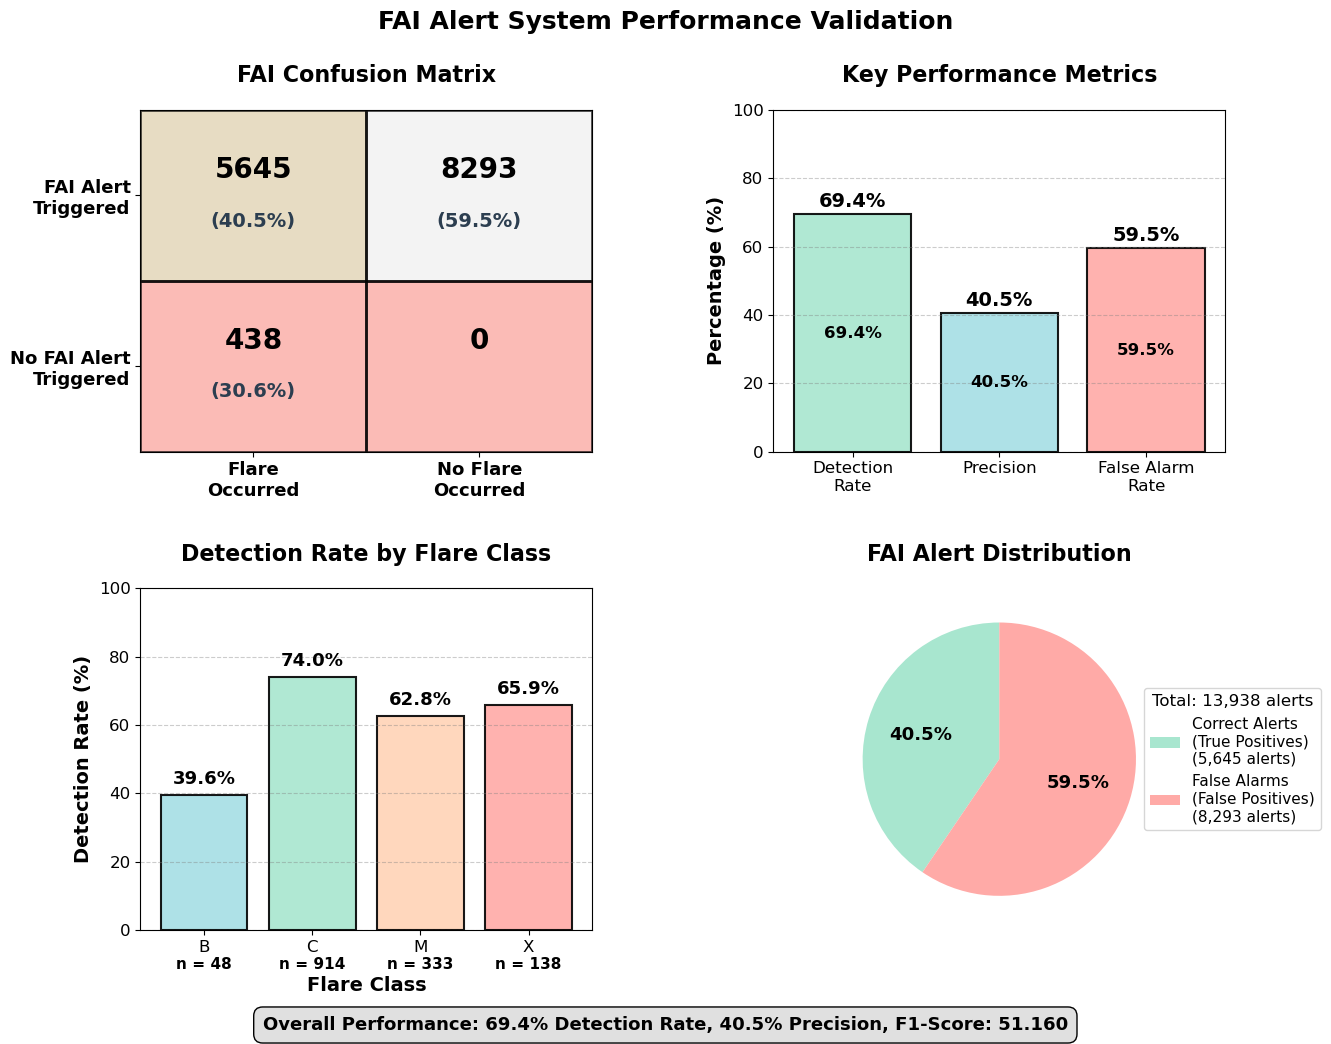


KEY PERFORMANCE METRICS FOR THESIS
• Total Flares Analyzed: 1,433
• Total FAI Alerts: 13,938
• True Positives (Correct Alerts): 5,645
• False Positives (False Alarms): 8,293
• False Negatives (Missed Flares): 438
• Detection Rate: 69.4%
• Precision: 40.5%
• False Alarm Rate: 59.5%
• F1-Score: 51.160
• Alerts per Detected Flare: 5.67
• Signal-to-Noise Ratio: 0.68


In [73]:
# Validación completa con gráficos
validation_results = comprehensive_fai_validation(df_anticipation_time, df_fai_assoc, save_plots=True)